In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import geopandas as gpd
%pylab inline
import math
import osmnx as ox, networkx as nx
ox.config(log_file=True, log_console=True, use_cache=True)
import shapely
from shapely import geometry
import collections
from fiona.crs import from_epsg
from shapely.ops import nearest_points
from shapely.geometry import Point, MultiPoint
import mplleaflet
from arcgis import GIS

Populating the interactive namespace from numpy and matplotlib


In [27]:
from osgeo import ogr

In [14]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


### 1. Data imports

In [2]:
repo_path = "C:\\Users\\wb375969\\Desktop\\data_repo\\"
shelter = gpd.read_file("data/SHAPE/liste_abris_2017.shp")
hospital = pd.read_csv("data/updated_hospital_haiti.csv", encoding = 'ISO-8859-1')

In [3]:
hospital['lonlat'] = list(zip(hospital.lon.values, hospital.lat.values))
hospital['geometry'] = hospital['lonlat'].map(lambda x: shapely.geometry.Point(list(x)))
hospital = gpd.GeoDataFrame(hospital)

In [4]:
haiti_ADM = gpd.GeoDataFrame.from_file('haiti_boundary/haiti_adm4_minustah.shp')

In [5]:
gis = GIS(url='https://nkwjones.maps.arcgis.com',username='nj935_',password='Bemelmans1')
print("Logged on as {}".format(gis.properties.user["username"]))

Logged on as nj935_


In [6]:
world_boundaries = gis.content.get("2b93b06dc0dc4e809d3c8db5cb96ba69")
boundary_lyr = world_boundaries.layers[0]

In [7]:
query = boundary_lyr.query(where = "Country='Haiti'")
query.df

,AFF_ISO,COUNTRYAFF,Country,FID,ISO,SHAPE
0,HT,Haiti,Haiti,126,HT,"{'spatialReference': {'latestWkid': 3857, 'wki..."


In [8]:
HT_geom = query.features

In [9]:
world_borders = gpd.read_file(repo_path+"TM_WORLD_BORDERS-0.3.shp")
world_borders.set_index('NAME',inplace=True)
HT_shape = world_borders.loc['Haiti','geometry']

In [15]:
m = gis.map("Haiti")
m

MapView(layout=Layout(height='400px', width='100%'))

In [ ]:
HT_shape_gdf = gpd.GeoDataFrame.from_dict({"NAME":"Haiti","geometry":HT_shape})

### 2. Make fishnet

In [31]:
import os, sys
from osgeo import ogr
from math import ceil
# the code is from this reference: http://varunpant.com/posts/how-to-create-fishnets-or-geospatial-grids

In [44]:
#https://gis.stackexchange.com/questions/2951/algorithm-for-offsetting-a-latitude-longitude-by-some-amount-of-meters

#Find one location to represent the area
lat = 20.218137
lon = -71.62213
R=6378137 # Earth’s radius, sphere
dn = 2500 #the width of each grid unit in meters
de = 2500 #the height of each grid unit in meters
# Coordinate offsets in radians
dLat = dn/R
dLon = de/(R*math.cos(math.pi*lat/180))
# OffsetPosition, decimal degrees
latO = dLat * 180/math.pi # the corresponding latitude for each grid unit's width
lonO = dLon * 180/math.pi # the corresponding latitude for each grid unit's height

In [45]:
print(latO,lonO)

0.02245788210298804 0.0239325158629612


In [65]:
#!python grid.py grid.shp -75.238462 -71.62213 17.909929 20.218137 0.008983152841195214 0.00957300634518448

In [47]:
def main(outputGridfn,xmin,xmax,ymin,ymax,gridHeight,gridWidth):

    # convert sys.argv to float
    xmin = float(xmin)
    xmax = float(xmax)
    ymin = float(ymin)
    ymax = float(ymax)
    gridWidth = float(gridWidth)
    gridHeight = float(gridHeight)

    # get rows
    rows = ceil((ymax-ymin)/gridHeight)
    # get columns
    cols = ceil((xmax-xmin)/gridWidth)

    # start grid cell envelope
    ringXleftOrigin = xmin
    ringXrightOrigin = xmin + gridWidth
    ringYtopOrigin = ymax
    ringYbottomOrigin = ymax-gridHeight

    # create output file
    outDriver = ogr.GetDriverByName('ESRI Shapefile')
    if os.path.exists(outputGridfn):
        os.remove(outputGridfn)
    outDataSource = outDriver.CreateDataSource(outputGridfn)
    outLayer = outDataSource.CreateLayer(outputGridfn,geom_type=ogr.wkbPolygon )
    featureDefn = outLayer.GetLayerDefn()

    # create grid cells
    countcols = 0
    while countcols < cols:
        countcols += 1

        # reset envelope for rows
        ringYtop = ringYtopOrigin
        ringYbottom =ringYbottomOrigin
        countrows = 0

        while countrows < rows:
            countrows += 1
            ring = ogr.Geometry(ogr.wkbLinearRing)
            ring.AddPoint(ringXleftOrigin, ringYtop)
            ring.AddPoint(ringXrightOrigin, ringYtop)
            ring.AddPoint(ringXrightOrigin, ringYbottom)
            ring.AddPoint(ringXleftOrigin, ringYbottom)
            ring.AddPoint(ringXleftOrigin, ringYtop)
            poly = ogr.Geometry(ogr.wkbPolygon)
            poly.AddGeometry(ring)

            # add new geom to layer
            outFeature = ogr.Feature(featureDefn)
            outFeature.SetGeometry(poly)
            outLayer.CreateFeature(outFeature)
            outFeature.Destroy

            # new envelope for next poly
            ringYtop = ringYtop - gridHeight
            ringYbottom = ringYbottom - gridHeight

        # new envelope for next poly
        ringXleftOrigin = ringXleftOrigin + gridWidth
        ringXrightOrigin = ringXrightOrigin + gridWidth

    # Close DataSources
    outDataSource.Destroy()


main('grid.shp',-75.238462,-71.62213,17.909929,20.218137,latO,lonO)

In [48]:
fishnet = gpd.GeoDataFrame.from_file('grid.shp')
fishnet['centroid_point'] = fishnet.centroid

In [21]:
#fishnet.set_geometry('centroid_point',inplace=True)

In [50]:
fishnet.shape

(15656, 3)

In [51]:
fishnet['in_HT']=np.zeros(fishnet.shape[0])

countA = 0
listA = []
for i, point in enumerate(fishnet.centroid_point):
        if HT_shape.contains(point):
            fishnet.in_HT[i] = True

C:\WBG\anaconda\envs\core_env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\WBG\anaconda\envs\core_env\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


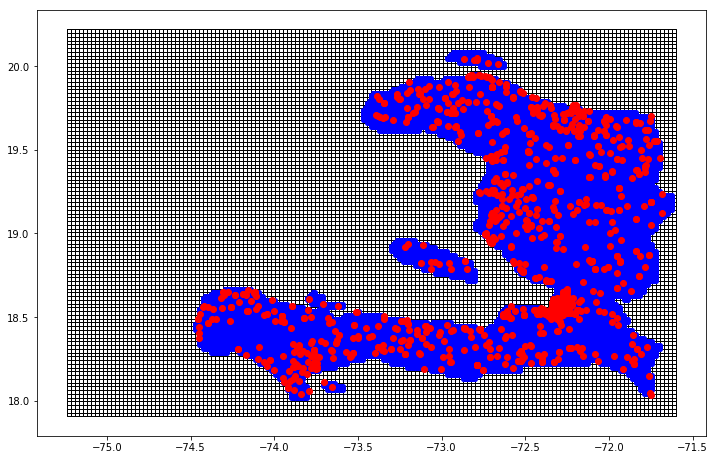

In [52]:
base = fishnet.plot(color='white',edgecolor='k',figsize=[12,12])
fishnet[fishnet.in_HT==True].plot(edgecolor='b',facecolor='none',ax=base,lw=5)
hospital.plot(ax=base,color='r')
#HT_shape_gdf.plot(ax=base,edgecolor='blue',facecolor='none',lw=5)


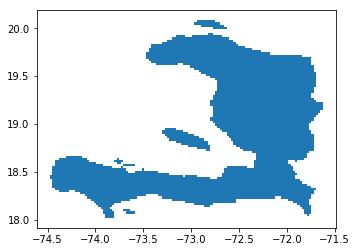

In [53]:
fishnet2=fishnet[fishnet.in_HT==True]
fishnet2.plot()

### 3. Find distance as crow flies

In [73]:
points = fishnet2.centroid_point
hospital_locations = hospital.geometry
shelter_locations = shelter.geometry

In [79]:
shelter_dist = np.empty(len(points))
hospital_dist = np.empty(len(points))

for i, point in enumerate(points):
    hospital_dist[i] = np.min([point.distance(location) for location in hospital_locations])
    shelter_dist[i] = np.min([point.distance(location) for location in shelter_locations])

fishnet2['hospital_dist'] = hospital_dist
fishnet2['shelter_dist'] = shelter_dist

C:\WBG\anaconda\envs\core_env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\WBG\anaconda\envs\core_env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


C:\WBG\anaconda\envs\core_env\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Distance (lat/lon degrees)')

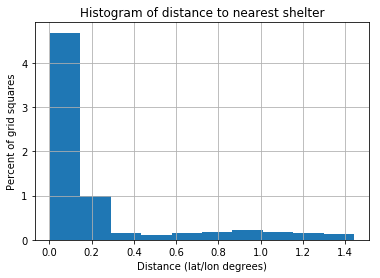

In [75]:
pd.Series(shelter_dist).hist(normed=True)
plt.title('Histogram of distance to nearest shelter')
plt.ylabel('Percent of grid squares')
plt.xlabel('Distance (lat/lon degrees)')


In [61]:
fishnet2.set_geometry('geometry',inplace=True)

C:\WBG\anaconda\envs\core_env\lib\site-packages\geopandas\geodataframe.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame[geo_column_name] = level


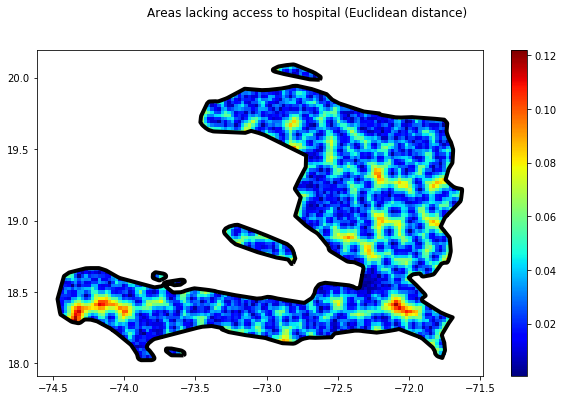

In [88]:
f,ax = plt.subplots(figsize=[10,6])
fishnet2.plot(column='hospital_dist',cmap='jet',legend=True,ax=ax)
f.suptitle('Areas lacking access to hospital (Euclidean distance)');
HT_shape_gdf.plot(ax=ax,edgecolor='k',facecolor='none',lw=4)
#hospital.plot(ax=ax)


### 4. Find distance through road travel

In [89]:

#download the road network in Haiti
G = ox.graph_from_place('Haiti', network_type='drive_service') 


SSLError: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?format=json&limit=1&dedupe=0&polygon_geojson=1&q=Haiti (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'ssl3_get_server_certificate', 'certificate verify failed')],)",),))

In [ ]:
#### Next steps:
* get network-based distances
* weight by mean travel speed
* 